<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural-networks/Basic/KAN_vs_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pykan

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from kan import KAN, create_dataset

## Create dataset

In [5]:
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2).float()
dataset = create_dataset(f, n_var=2)
dataset['train_input'] = dataset['train_input'].float()
dataset['train_label'] = dataset['train_label'].float()

## Create KAN model

In [ ]:
kan_model = KAN(width=[2, 5, 1], grid=5, k=3, seed=0)

kan_optimizer = optim.LBFGS(kan_model.parameters(), lr=1)

## Create MLP

In [37]:
mlp_model = nn.Sequential(
                          nn.Linear(2, 5),
                          nn.ReLU(),
                          nn.Linear(5, 5),
                          nn.ReLU(),
                          nn.Linear(5, 1))

for param in mlp_model.parameters():
    param.data = param.data.float()


mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

## Create metrics

In [11]:
def mse(y_true, y_pred):
    return ((y_pred - y_true) ** 2).mean()

def rmse(y_true, y_pred):
    return torch.sqrt(mse(y_true, y_pred))


def evaluate_model(model, dataset):
    with torch.no_grad():
        outputs = model(dataset['test_input'])
        mse_value = mse(dataset['test_label'], outputs).item()
        rmse_value = rmse(dataset['test_label'], outputs).item()
    return mse_value, rmse_value

In [39]:
def train_mlp(model, optimizer, epochs=20, dataset=dataset):
    criterion = nn.MSELoss()
    mse_history = []
    rmse_history = []

    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()
            outputs = model(dataset['train_input'])
            loss = criterion(outputs, dataset['train_label'])
            loss.backward()
            return loss

        optimizer.step(closure)
        with torch.no_grad():
            outputs = model(dataset['train_input'])
            current_mse = mse(dataset['train_label'], outputs)
            current_rmse = rmse(dataset['train_label'], outputs)

        mse_history.append(current_mse.item())
        rmse_history.append(current_rmse.item())

    return mse_history, rmse_history, model


## train mlp

Let's give MLP some (x10) advantage

In [43]:
mse_hist, rmse_hist, mlp_model = train_mlp(mlp_model, mlp_optimizer, epochs=200)

## train KAN

In [ ]:
kan_model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.)

## Create predictions

In [44]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
xy = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=-1), dtype=torch.float32)

true_values = f(xy).reshape(100, 100).numpy()

with torch.no_grad():
    kan_predictions = kan_model(xy).reshape(100, 100).numpy()
    mlp_predictions = mlp_model(xy).reshape(100, 100).numpy()


## Plot predictions

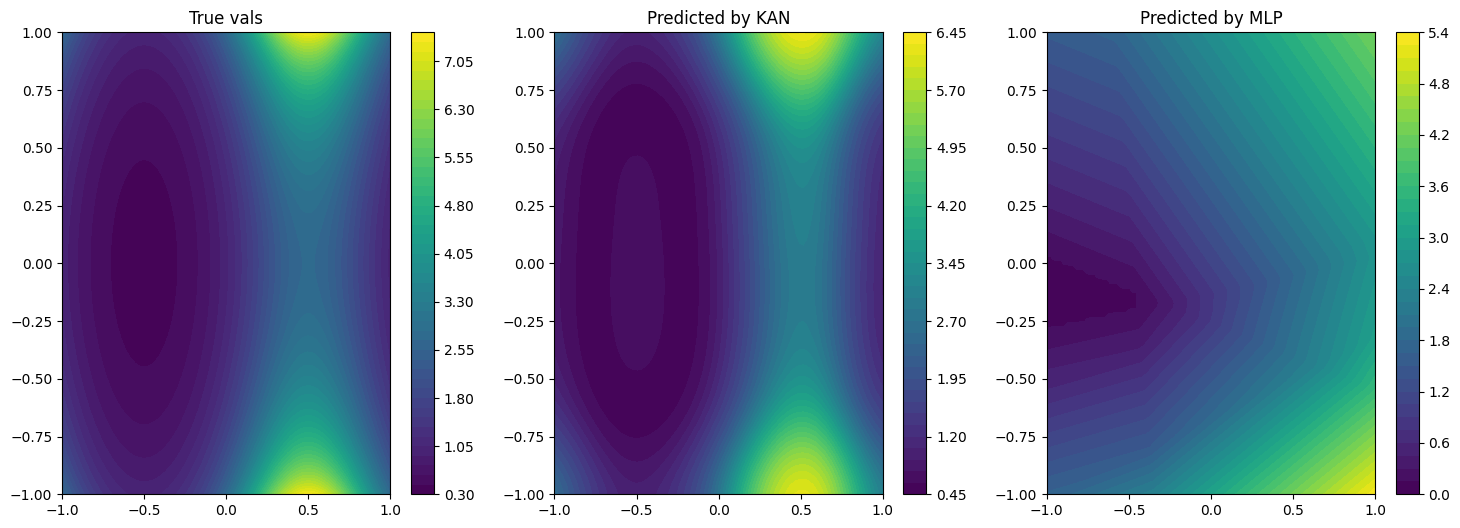

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

c = ax[0].contourf(X, Y, true_values, levels=50, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_title('True vals')

c = ax[1].contourf(X, Y, kan_predictions, levels=50, cmap='viridis')
fig.colorbar(c, ax=ax[1])
ax[1].set_title('Predicted by KAN')

c = ax[2].contourf(X, Y, mlp_predictions, levels=50, cmap='viridis')
fig.colorbar(c, ax=ax[2])
ax[2].set_title('Predicted by MLP')

plt.show()


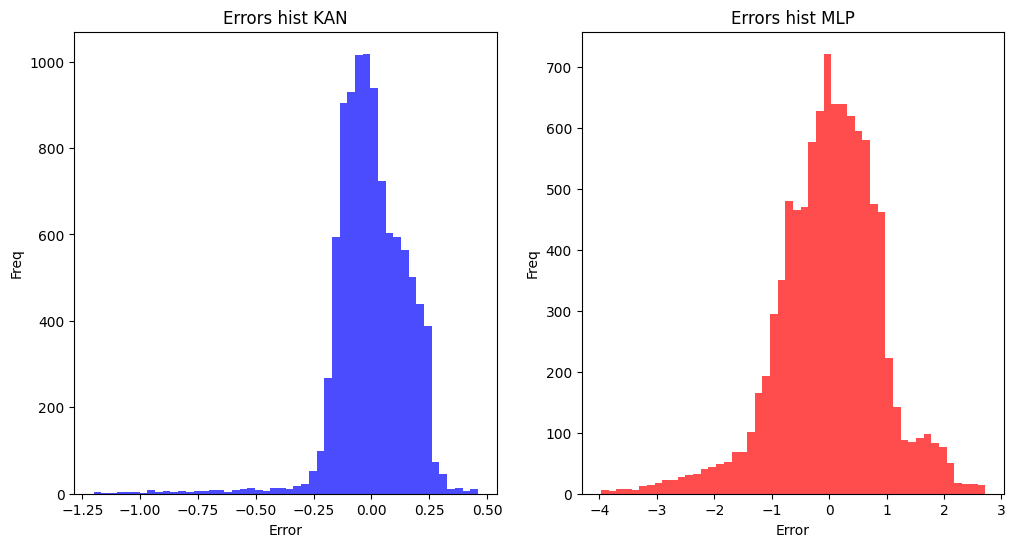

In [46]:
kan_errors = (kan_predictions - true_values).ravel()
mlp_errors = (mlp_predictions - true_values).ravel()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(kan_errors, bins=50, color='blue', alpha=0.7)
ax[0].set_title('Errors hist KAN')
ax[0].set_xlabel('Error')
ax[0].set_ylabel('Freq')

ax[1].hist(mlp_errors, bins=50, color='red', alpha=0.7)
ax[1].set_title('Errors hist MLP')
ax[1].set_xlabel('Error')
ax[1].set_ylabel('Freq')

plt.show()

## Another experiment

In [27]:
test_dataset = create_dataset(f, n_var=2)
test_dataset['test_input'] = test_dataset['test_input'].float()
test_dataset['test_label'] = test_dataset['test_label'].float()

In [47]:
kan_mse, kan_rmse = evaluate_model(kan_model, test_dataset)
mlp_mse, mlp_rmse = evaluate_model(mlp_model, test_dataset)

print("KAN Model:")
print("MSE on test set:", kan_mse)
print("RMSE on test set:", kan_rmse)

print("\nMLP Model:")
print("MSE on test set:", mlp_mse)
print("RMSE on test set:", mlp_rmse)


KAN Model:
MSE on test set: 0.01784814534873098
RMSE on test set: 0.13359695112064116

MLP Model:
MSE on test set: 0.7641071677207947
RMSE on test set: 0.8741322159767151


Nothe that mlp has been trained for 200 epochs

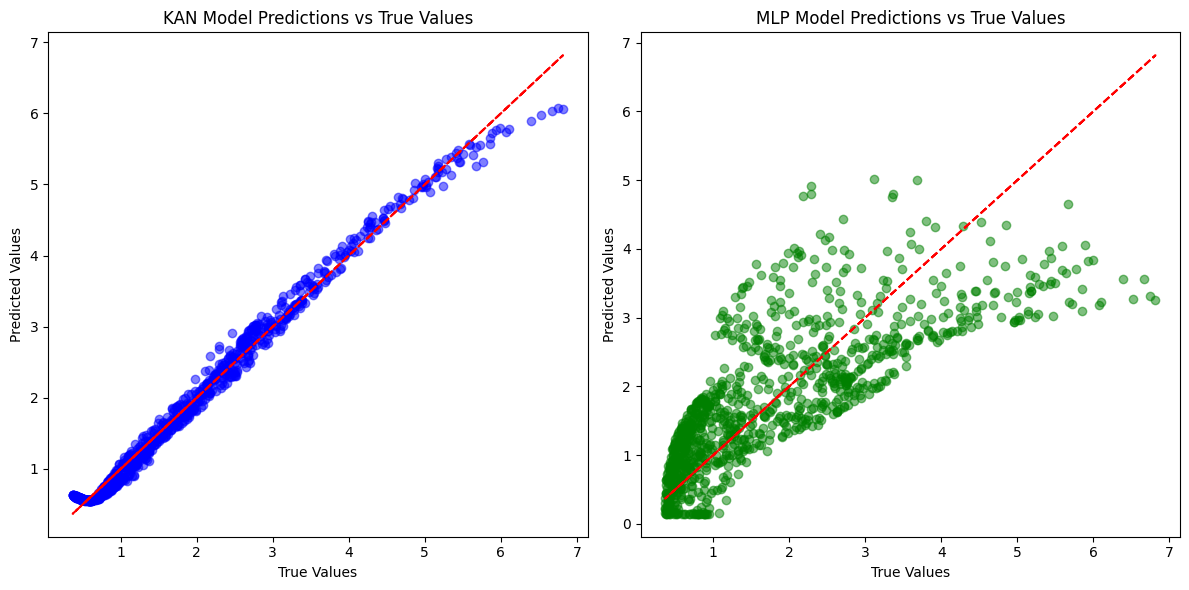

In [48]:
with torch.no_grad():
    kan_test_predictions = kan_model(test_dataset['test_input']).numpy()
    mlp_test_predictions = mlp_model(test_dataset['test_input']).numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(test_dataset['test_label'], kan_test_predictions, color='blue', alpha=0.5)
ax[0].plot(test_dataset['test_label'], test_dataset['test_label'], color='red', linestyle='--')
ax[0].set_title('KAN Model Predictions vs True Values')
ax[0].set_xlabel('True Values')
ax[0].set_ylabel('Predicted Values')

ax[1].scatter(test_dataset['test_label'], mlp_test_predictions, color='green', alpha=0.5)
ax[1].plot(test_dataset['test_label'], test_dataset['test_label'], color='red', linestyle='--')
ax[1].set_title('MLP Model Predictions vs True Values')
ax[1].set_xlabel('True Values')
ax[1].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()


Nuff said